In [71]:
import pandas as pd
import matplotlib.pyplot as plt
# In AAPL.ipynb
from stock_data import StockData
# Make plots a bit nicer
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)
from dateutil import parser

from pandas.tseries.offsets import BDay

import seaborn as sns



## Load or download a data (AMZN)

In [72]:
# ============================================
# Download AAPL daily data for a year
# ============================================

ticker = "AMZN"

stock = StockData(ticker, start_date="2009-02-14", end_date="2020-06-03")

df = stock.load_data()
df.head()



C:\Users\Birhanu Matebe\Downloads\KAIM\Finanicial-Data-Analysis\Financial-Data-Analysis\src\stock_data.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.df = yf.download(


Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2009-02-17,3.0835,3.1325,3.0590,3.0835,142522000
2009-02-18,3.1175,3.1390,3.0260,3.1135,147320000
2009-02-19,3.0975,3.2090,3.0835,3.1420,135378000
2009-02-20,3.1930,3.2075,3.0420,3.0535,187090000
2009-02-23,3.0855,3.2455,3.0760,3.2080,146720000


In [73]:
sentiment_df = pd.read_csv("../data/daily_sentiment.csv")

In [74]:
sentiment_df.head()

,headline,url,publisher,date,stock,headline_length,TextBlob_Sentiment,TextBlob_Category
0,How Treasuries and ETFs Work,https://www.benzinga.com/28044/how-treasuries-...,Paco Ahlgren,2009-02-14 00:00:00+00:00,NAV,28,0.0,Neutral
1,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,Charles Lewis Sizemore CFA,2009-04-27 00:00:00+00:00,Y,45,0.0,Neutral
2,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,Charles Lewis Sizemore CFA,2009-04-27 00:00:00+00:00,FT,45,0.0,Neutral
3,Going Against the Herd,https://www.benzinga.com/charles-lewis-sizemor...,Charles Lewis Sizemore CFA,2009-04-29 00:00:00+00:00,A,22,0.0,Neutral
4,Charles Sizemore Radio Interview Saturday Morning,https://www.benzinga.com/11218/charles-sizemor...,Charles Lewis Sizemore CFA,2009-05-22 00:00:00+00:00,AM,49,0.0,Neutral


# 1. Data profiling

In [75]:
# ============================================
# Clean the columns (handle MultiIndex case)
# ============================================

# If columns are MultiIndex (like: ('Close', 'TSLA')), flatten them

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)  # keep only first level: Open, High, etc.

print("Cleaned columns:", df.columns.tolist())

# Optional: add a Ticker column (useful if using multiple tickers later)
df["Ticker"] = ticker

# Ensure index is datetime and sorted
df.index = pd.to_datetime(df.index)
df = df.sort_index()




Cleaned columns: ['Close', 'High', 'Low', 'Open', 'Volume']


# - Summary Statistics 

In [76]:


stock.inspect_data()




📌 Dataset Shape for AMZN: (2843, 6)

📌 First 5 rows:


Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2009-02-17,3.0835,3.1325,3.0590,3.0835,142522000,AMZN
2009-02-18,3.1175,3.1390,3.0260,3.1135,147320000,AMZN
2009-02-19,3.0975,3.2090,3.0835,3.1420,135378000,AMZN
2009-02-20,3.1930,3.2075,3.0420,3.0535,187090000,AMZN
2009-02-23,3.0855,3.2455,3.0760,3.2080,146720000,AMZN



📌 Last 5 rows:


Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2020-05-27,120.519501,120.679001,116.500000,120.249496,101138000,AMZN
2020-05-28,120.055000,121.848503,118.911499,119.216499,63804000,AMZN
2020-05-29,122.118500,122.118500,119.910004,120.796997,70198000,AMZN
2020-06-01,123.552002,123.846497,122.208504,122.400002,58578000,AMZN
2020-06-02,123.620499,123.676498,122.265503,123.349998,50598000,AMZN



📌 Random 5 rows:


Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2014-11-24,16.782000,16.869499,16.680000,16.739000,55084000,AMZN
2018-04-12,72.425003,72.606003,71.752998,71.974998,62700000,AMZN
2018-03-19,77.246498,78.083000,76.267502,77.726501,131616000,AMZN
2016-08-10,38.428001,38.605000,38.309502,38.490002,32086000,AMZN
2009-08-14,4.179000,4.208500,4.139000,4.205500,98494000,AMZN



📌 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2843 entries, 2009-02-17 to 2020-06-02
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2843 non-null   float64
 1   High    2843 non-null   float64
 2   Low     2843 non-null   float64
 3   Open    2843 non-null   float64
 4   Volume  2843 non-null   int64  
 5   Ticker  2843 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 155.5+ KB


In [77]:
key_cols = ['Close', 'Open', 'High', 'Volume', 'Ticker']





stock.check_missing_values()




📌 Missing values per column:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
Ticker    0
dtype: int64

📌 Columns with >5% missing values:
✔️ None

📌 Total rows with missing values in key columns ['Close', 'Open', 'High', 'Volume']: 0
✔️ No missing rows in key columns

📌 Duplicate rows: 0

📌 Cardinality (categoricals): {'Ticker': 1}


In [78]:
# log statistical data values
print("The description of the numeric columns:")
print(df.describe())

The description of the numeric columns:
Price        Close         High          Low         Open        Volume
count  2843.000000  2843.000000  2843.000000  2843.000000  2.843000e+03
mean     34.141675    34.486313    33.755467    34.139916  9.693791e+07
std      31.657144    31.971830    31.305281    31.657388  6.419352e+07
min       3.024500     3.132500     2.991000     3.053500  1.762600e+07
25%      10.094500    10.257250     9.868500    10.060500  5.790500e+07
50%      17.988001    18.143499    17.775000    17.948999  8.055800e+07
75%      49.041000    49.458500    48.737249    49.181002  1.155640e+08
max     124.897003   126.272499   123.363503   125.000000  1.166116e+09


In [79]:
#Overview of categorical columns
print("The description of the categorical columns:")
print(df.describe(include=['object']))

The description of the categorical columns:
Price  Ticker
count    2843
unique      1
top      AMZN
freq     2843


In [80]:
# log and check the frequency, and uniqueness of all dataset column
print("The description of all columns:")
print(df.describe(include='all'))


The description of all columns:
Price         Close         High          Low         Open        Volume  \
count   2843.000000  2843.000000  2843.000000  2843.000000  2.843000e+03   
unique          NaN          NaN          NaN          NaN           NaN   
top             NaN          NaN          NaN          NaN           NaN   
freq            NaN          NaN          NaN          NaN           NaN   
mean      34.141675    34.486313    33.755467    34.139916  9.693791e+07   
std       31.657144    31.971830    31.305281    31.657388  6.419352e+07   
min        3.024500     3.132500     2.991000     3.053500  1.762600e+07   
25%       10.094500    10.257250     9.868500    10.060500  5.790500e+07   
50%       17.988001    18.143499    17.775000    17.948999  8.055800e+07   
75%       49.041000    49.458500    48.737249    49.181002  1.155640e+08   
max      124.897003   126.272499   123.363503   125.000000  1.166116e+09   

Price  Ticker  
count    2843  
unique      1  
top    

In [81]:
#check if duplication of rows exist
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

Duplicate rows: 0


In [82]:
# Cardinality (uniqueness) for categoricals
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = {c: df[c].nunique() for c in cat_cols}
print("Cardinality (categoricals):", cardinality)

Cardinality (categoricals): {'Ticker': 1}


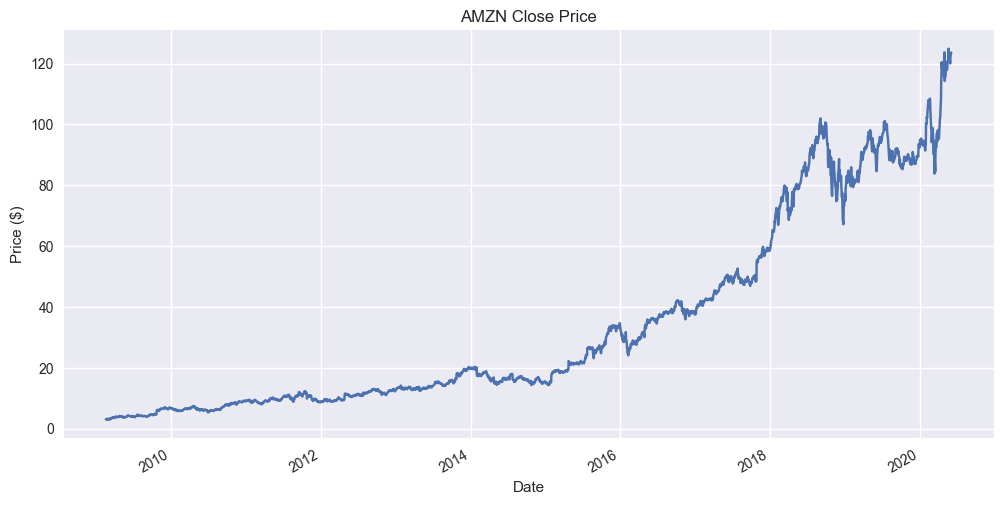

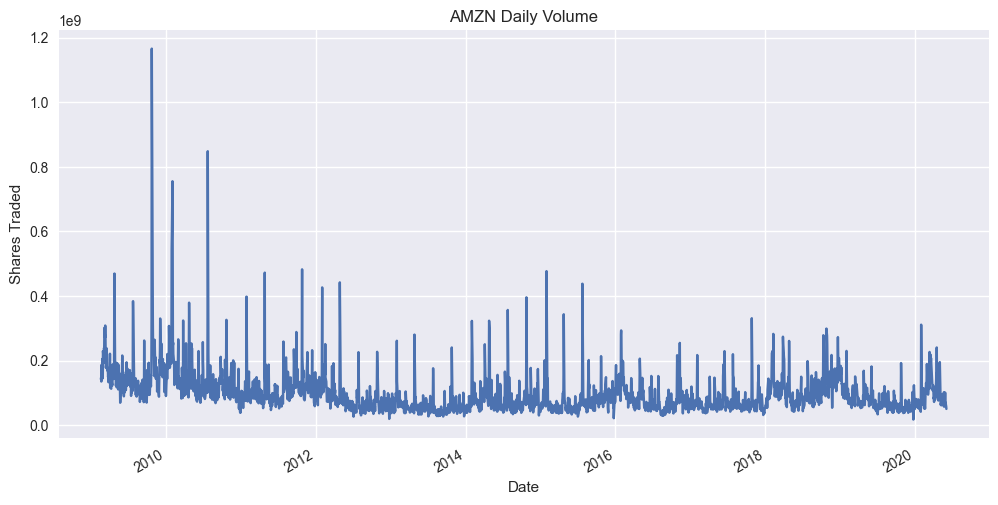

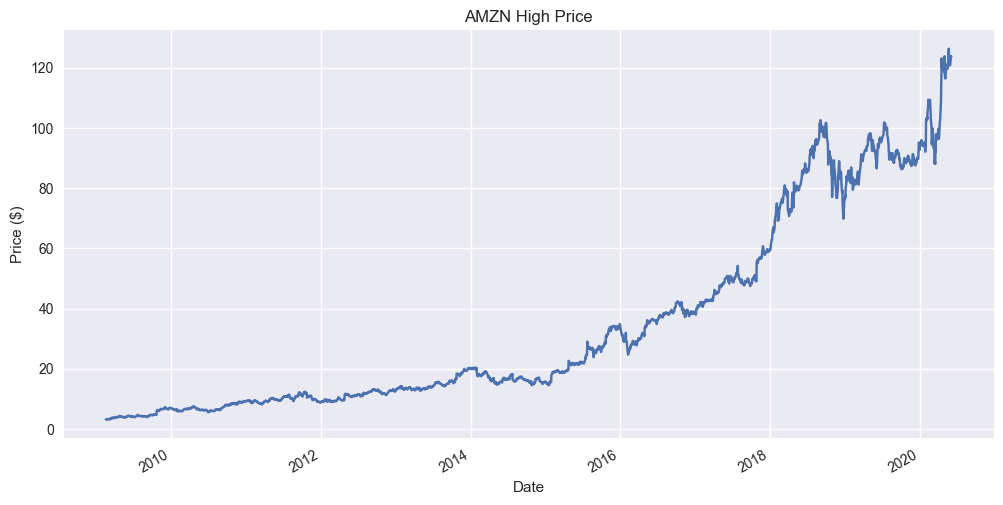

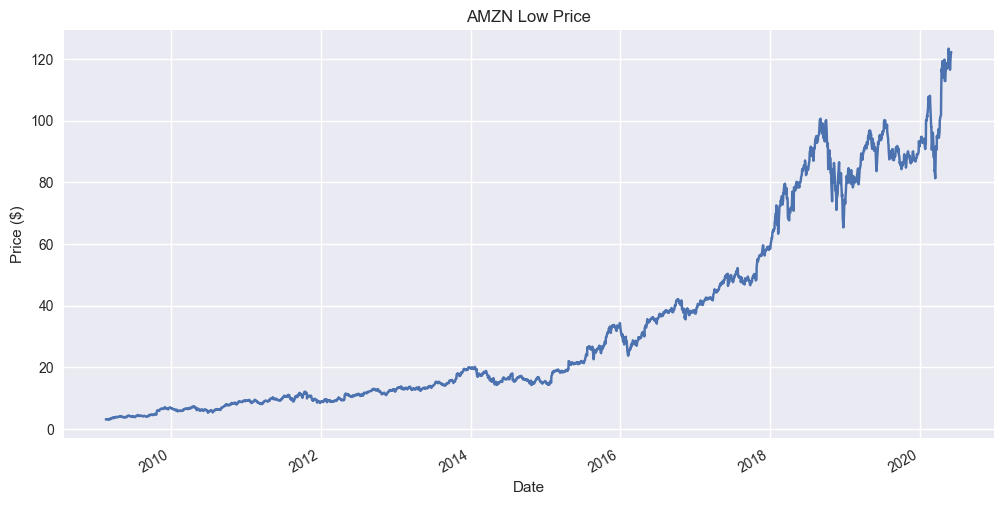

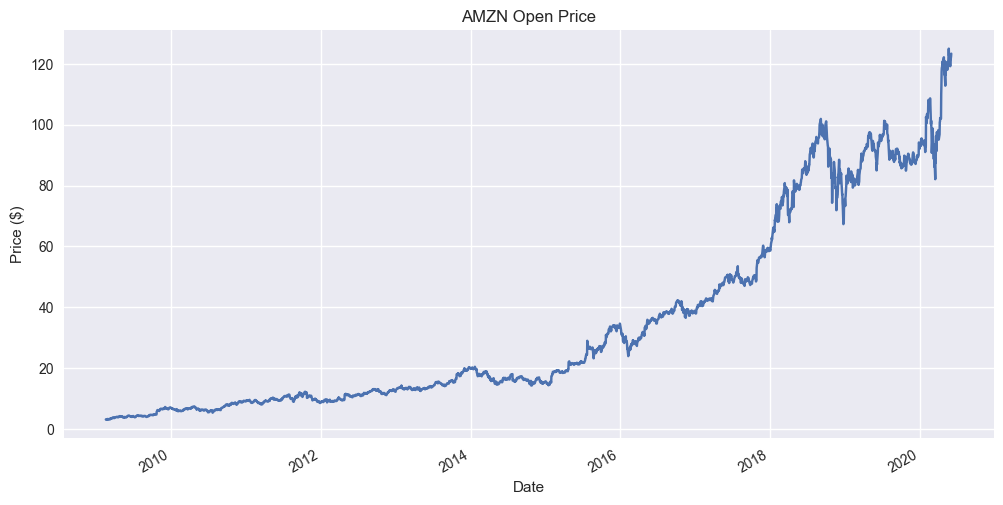

In [83]:

stock.plot_price()

## Stock price over time

## Interpretation of Amazon (AMZN) Close Price History (2009–2024)

- Overall Trend: The price exhibits a near-vertical, relentless uptrend for the entire decade. It starts near the $10 mark and ends near $120, representing massive growth.

- Minimal Pullbacks: Unlike the AAPL chart, which had a significant consolidation period (2012-2014), the AMZN chart shows very few major, prolonged pullbacks until late 2018. This suggests extremely strong investor conviction and continuous positive momentum.
- Key Growth Phases:

- 2010-2015: Steady climb from $\sim\$10$ to $\sim\$30$.

- 2015-2018: The growth accelerates sharply, moving from $\sim\$30$ to a peak near $\sim\$100$.

- 2018 Volatility: A noticeable, sharp correction/pullback occurs in late 2018 (from $\sim\$100$ down to $\sim\$70$), but the price quickly recovers.

- Final Surge: The chart ends with a dramatic surge, pushing the price past the $\mathbf{\$120}$ mark.

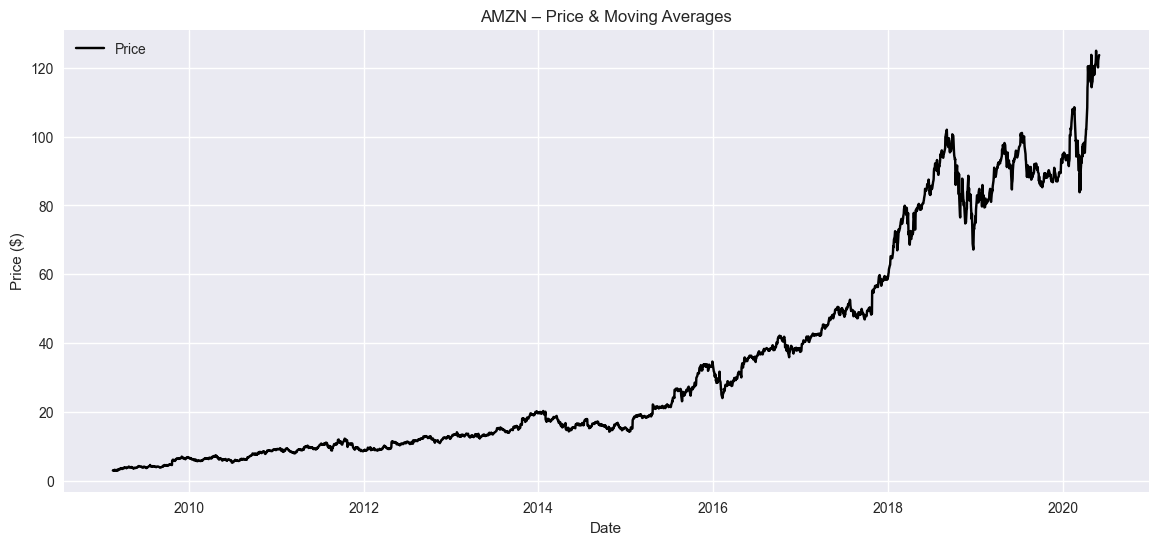

In [84]:
stock.plot_price_sma()


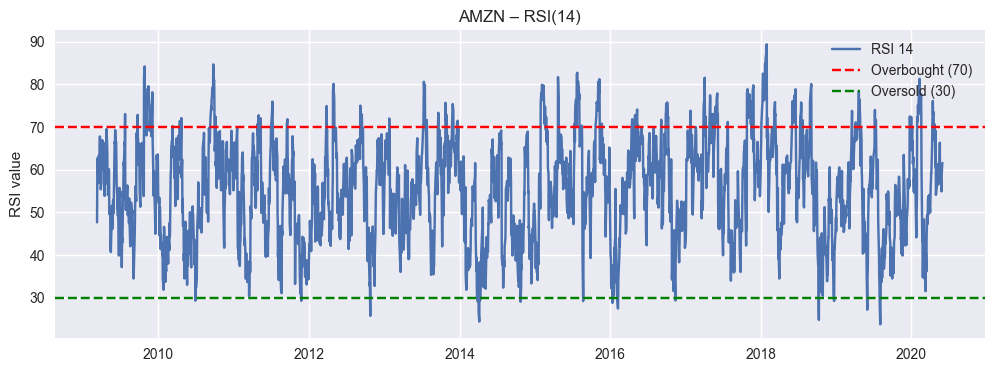

In [85]:



stock.plot_rsi()



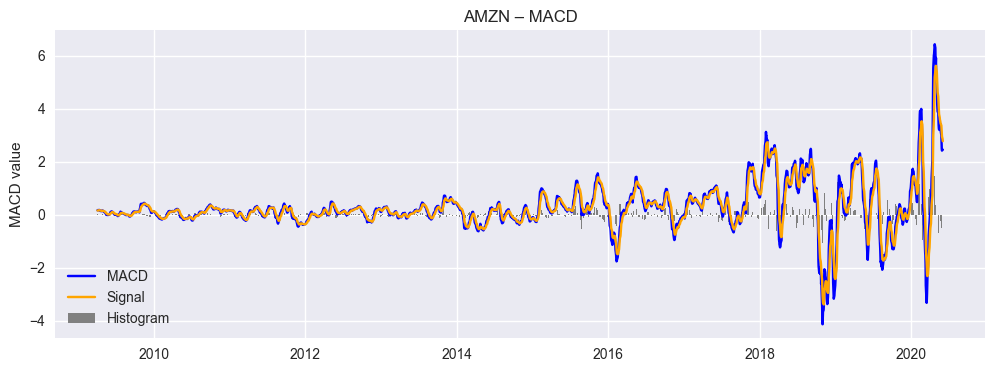

In [86]:
stock.plot_macd()


## Interpretation of Amazon (AMZN) Price & Moving Averages (2009–2024)
- Relentless Uptrend: The primary feature is the powerful, sustained upward trend with minimal interruption. The price surges from near $5 in 2010 to over $120 by 2020. 

- Acceleration: Growth was steep and consistent, but dramatically accelerated from 2015 to 2018, where the price rocketed from the $30s to almost $100.

- Volatility: The steepest period of volatility and correction occurred in late 2018 (dropping from $\sim\$100$ to $\sim\$70$), but it was quickly followed by a rapid recovery and continued ascent.

- Technical Context (Implied MAs): Given the chart is titled "Price & Moving Averages," the constant upward movement implies the price was almost always above its key Moving Averages, and the shorter MAs were constantly above the longer MAs, confirming a healthy and aggressive bullish trend.

## Interpretation of Amazon (AMZN) Relative Strength Index (RSI 14)
- Overall Bullish Momentum: The RSI spends the vast majority of its time well above the 30 (Oversold) line and frequently pushes into the Overbought (above 70) zone. This pattern is characteristic of a strong, persistent uptrend.

- Strong Buying Pressure: The RSI hits or exceeds the 70 (Overbought) line often, showing that the stock's rallies have strong, rapid momentum. The fact that it often remains in this upper range for extended periods confirms that investors are willing to keep buying even after large price increases.

- Minimal Selling Pressure: The RSI rarely dips into the 30 (Oversold) territory. When it does, it is usually very brief, indicating that any significant price drop is quickly met with strong buyer demand. This aligns perfectly with the almost uninterrupted upward price movement seen in the AMZN price chart.

## Interpretation of Amazon (AMZN) MACD
- Bullish Trend Validation: The MACD line and its Signal line remain largely above the zero line, confirming the aggressive, non-stop uptrend of AMZN stock.

- Momentum Swings: The amplitude of the swings (distance from the zero line) remains relatively contained until around 2016-2017, after which the volatility of the momentum increases dramatically.

- Strong Signals: Bullish crossovers (MACD above Signal) occurring near or below the zero line (e.g., after the late 2018 correction) align with the powerful continuation of the upward trend.

In [87]:
df.head()

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2009-02-17,3.0835,3.1325,3.0590,3.0835,142522000,AMZN
2009-02-18,3.1175,3.1390,3.0260,3.1135,147320000,AMZN
2009-02-19,3.0975,3.2090,3.0835,3.1420,135378000,AMZN
2009-02-20,3.1930,3.2075,3.0420,3.0535,187090000,AMZN
2009-02-23,3.0855,3.2455,3.0760,3.2080,146720000,AMZN


In [88]:

def safe_parse_with_utc(date_val):
    try:
        dt = parser.parse(str(date_val), dayfirst=False)  # adjust dayfirst if your dataset is DD-MM-YYYY
        return pd.Timestamp(dt, tz='UTC')
    except:
        return pd.NaT

if 'date' in df.columns:
    df['date'] = df['date'].astype(str).str.strip()
    df['date'] = df['date'].apply(safe_parse_with_utc)
    
    if df['date'].isnull().any():
        print("Warning: Some dates could not be parsed and are set as NaT.")
    
    df = df.sort_values('date').reset_index(drop=True)
    
    print(df['date'].head())
    print(f"Data type: {df['date'].dtype}")


In [89]:
df.head()

Price,Close,High,Low,Open,Volume,Ticker
Date,,,,,,
2009-02-17,3.0835,3.1325,3.0590,3.0835,142522000,AMZN
2009-02-18,3.1175,3.1390,3.0260,3.1135,147320000,AMZN
2009-02-19,3.0975,3.2090,3.0835,3.1420,135378000,AMZN
2009-02-20,3.1930,3.2075,3.0420,3.0535,187090000,AMZN
2009-02-23,3.0855,3.2455,3.0760,3.2080,146720000,AMZN


In [90]:
print(sentiment_df.columns.tolist())


['headline', 'url', 'publisher', 'date', 'stock', 'headline_length', 'TextBlob_Sentiment', 'TextBlob_Category']


In [91]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.strftime('%Y-%m-%d')


In [92]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])


In [93]:


# Assuming your DataFrame is loaded as 'sentiment_df'
# and the ticker column is named 'stock'.

# 1. Check if 'AMZN' exists anywhere in the 'stock' column
is_amzn_present = sentiment_df['stock'].isin(['AMZN']).any()

print(f"Is AMZN present in the stock column? {is_amzn_present}")

# 2. OPTIONAL: To see how many rows contain 'AMZN':
amzn_count = sentiment_df['stock'].str.contains('AMZN', na=False).sum()
print(f"Total count of rows mentioning AMZN: {amzn_count}")

Is AMZN present in the stock column? True
Total count of rows mentioning AMZN: 268


In [94]:
sentiment_df.sample(20)


,headline,url,publisher,date,stock,headline_length,TextBlob_Sentiment,TextBlob_Category
198419,BlackRock Posts Higher Profit,https://www.benzinga.com/news/earnings/11/10/1...,Benzinga Staff Writer,2011-10-19,BLK,29,0.250000,Positive
679816,CIGNA CEO Explains Why The Anthem-CIGNA Deal W...,https://www.benzinga.com/media/cnbc/15/07/5721...,Ritesh Anan,2015-07-30,ANTM,72,0.000000,Neutral
666819,California Committee Votes to Advance Bill to ...,https://www.benzinga.com/news/15/06/5622046/ca...,Charles Gross,2015-06-24,KOL,120,0.000000,Neutral
949621,UPDATE: S.Korea Military Reports N.Korea Missi...,https://www.benzinga.com/news/17/08/9986326/up...,Charles Gross,2017-08-28,EWJ,71,-0.100000,Negative
1212159,Achillion Pharmaceuticals Earlier Reported Q2 ...,https://www.benzinga.com/news/earnings/19/08/1...,Benzinga_Newsdesk,2019-08-08,ACHN,65,0.000000,Neutral
668372,Morning Market Losers,https://www.benzinga.com/news/15/06/5631975/mo...,Lisa Levin,2015-06-29,AGO,21,-0.200000,Negative
190837,UPDATE: Tombini Will Act to Keep Forex Markets...,https://www.benzinga.com/news/11/09/1939760/up...,Matthew Kennedy,2011-09-23,EWZ,117,0.142857,Positive
904998,Watch These 5 Huge Put Purchases In Friday Trade,https://www.benzinga.com/markets/options/17/04...,Lisa Levin,2017-04-21,ALR,48,0.400000,Positive
1202781,"Alphabet Surges After Q2 Earnings, Revenue Beats",https://www.benzinga.com/news/earnings/19/07/1...,Dave Royse,2019-07-25,GOOGL,48,0.000000,Neutral
819132,Gap Sees FY16 Adj. EPS $1.87-$1.92 vs $1.96 Est.,https://www.benzinga.com/news/16/08/8370486/ga...,Paul Quintaro,2016-08-18,GPS,48,0.000000,Neutral


In [95]:
sentiment_df[sentiment_df['stock'] == 'AMZN']


,headline,url,publisher,date,stock,headline_length,TextBlob_Sentiment,TextBlob_Category
1339179,"Apple And Amazon Earnings, Fed Meeting Among H...",https://www.benzinga.com/news/earnings/20/04/1...,JJ Kinahan,2020-04-27,AMZN,74,0.100000,Positive
1339180,SunTrust Robinson Humphrey Maintains Buy on Am...,https://www.benzinga.com/news/20/04/15885780/s...,Vick Meyer,2020-04-27,AMZN,84,0.000000,Neutral
1339181,Will COVID-19 Accelerate The Adoption Of Auton...,https://www.benzinga.com/news/20/04/15887271/w...,FreightWaves,2020-04-27,AMZN,61,0.400000,Positive
1339182,Amazon Statement Shows Co. Extends Closure Of ...,https://www.benzinga.com/news/20/04/15888140/a...,Benzinga Newsdesk,2020-04-27,AMZN,73,0.000000,Neutral
1339183,3 Sector ETFs For This Week's Earnings Parade,https://www.benzinga.com/news/earnings/20/04/1...,ETF Professor,2020-04-27,AMZN,45,-0.250000,Negative
...,...,...,...,...,...,...,...,...
1351083,Amazon Looks To Establish Supply Chain Trust W...,https://www.benzinga.com/news/20/06/16154615/a...,FreightWaves,2020-06-01,AMZN,71,0.136364,Positive
1351141,"Pepper Spray, Books On Racism, 'I Can't Breath...",https://www.benzinga.com/news/20/06/16156515/p...,Neer Varshney,2020-06-02,AMZN,103,0.500000,Positive
1351142,Tesla CEO Musk Says Other Three Officers Shoul...,https://www.benzinga.com/news/20/06/16156648/t...,Neer Varshney,2020-06-02,AMZN,81,-0.125000,Negative
1351145,4 Blue Chips That Lived Up To Their Title Duri...,https://www.benzinga.com/markets/20/06/1616175...,IAM Newswire,2020-06-02,AMZN,61,0.000000,Neutral



Pearson Correlation:
                     return  daily_sentiment  lagged_sentiment
return            1.000000        -0.028491         -0.170854
daily_sentiment  -0.028491         1.000000         -0.544919
lagged_sentiment -0.170854        -0.544919          1.000000

Spearman Correlation:
                     return  daily_sentiment  lagged_sentiment
return            1.000000        -0.029231         -0.178462
daily_sentiment  -0.029231         1.000000         -0.495385
lagged_sentiment -0.178462        -0.495385          1.000000

Kendall Correlation:
                     return  daily_sentiment  lagged_sentiment
return            1.000000        -0.026667         -0.106667
daily_sentiment  -0.026667         1.000000         -0.360000
lagged_sentiment -0.106667        -0.360000          1.000000


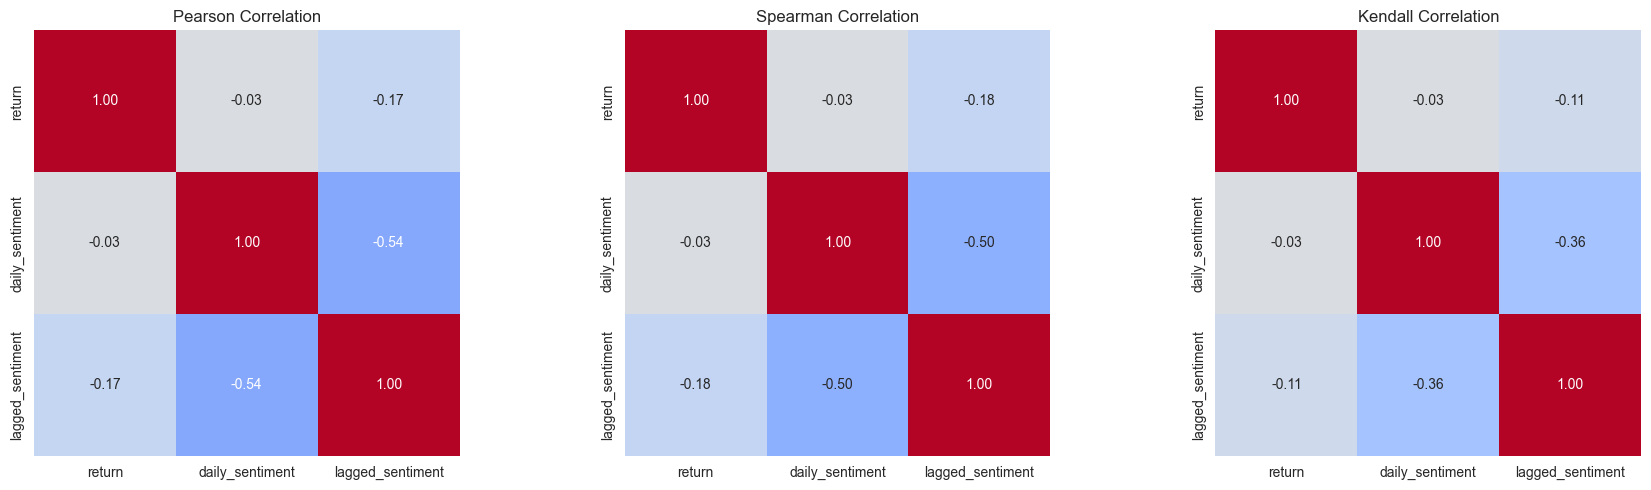

In [96]:


# -------------------------------
# 1. FILTER NEWS FOR AMZN ONLY
# -------------------------------
sentiment_df = sentiment_df[sentiment_df['stock'] == "AMZN"].copy()
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# -------------------------------
# 2. PREPARE STOCK DATA
# -------------------------------
# Ensure stock dataframe index is datetime
df.index = pd.to_datetime(df.index)

# -------------------------------
# 3. ALIGN NEWS DATES TO NEXT TRADING DAY
# -------------------------------
stock_dates = df.index

def align_to_next_trading_day(news_date):
    future_dates = stock_dates[stock_dates >= news_date]
    if len(future_dates) == 0:
        return None
    return future_dates[0]

sentiment_df['aligned_date'] = sentiment_df['date'].apply(align_to_next_trading_day)
sentiment_df = sentiment_df.dropna(subset=['aligned_date'])

# -------------------------------
# 4. AGGREGATE DAILY SENTIMENT
# -------------------------------
daily_sentiment = (
    sentiment_df.groupby('aligned_date')['TextBlob_Sentiment']
    .mean()
    .to_frame('daily_sentiment')
)

# Create lagged sentiment (previous day's sentiment)
daily_sentiment['lagged_sentiment'] = daily_sentiment['daily_sentiment'].shift(1)

# -------------------------------
# 5. CALCULATE DAILY STOCK RETURNS
# -------------------------------
df['return'] = df['Close'].pct_change()

# -------------------------------
# 6. MERGE STOCK + SENTIMENT
# -------------------------------
merged_df = df.merge(
    daily_sentiment,
    left_index=True,
    right_index=True,
    how='left'
)

# -------------------------------
# 7. CORRELATION ANALYSIS
# -------------------------------
# Drop NaNs for correlation calculation
df_corr = merged_df[['return', 'daily_sentiment', 'lagged_sentiment']].dropna()

corr_methods = {
    "Pearson": df_corr.corr(method="pearson"),
    "Spearman": df_corr.corr(method="spearman"),
    "Kendall": df_corr.corr(method="kendall"),
}

# Print correlations
for name, corr in corr_methods.items():
    print(f"\n{name} Correlation:\n", corr)

# -------------------------------
# 8. VISUALIZATION
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (title, corr) in zip(axes, corr_methods.items()):
    sns.heatmap(
        corr,
        ax=ax,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        annot=True,
        fmt=".2f",
        square=True,
        cbar=False
    )
    ax.set_title(f"{title} Correlation")

fig.tight_layout()
plt.show()


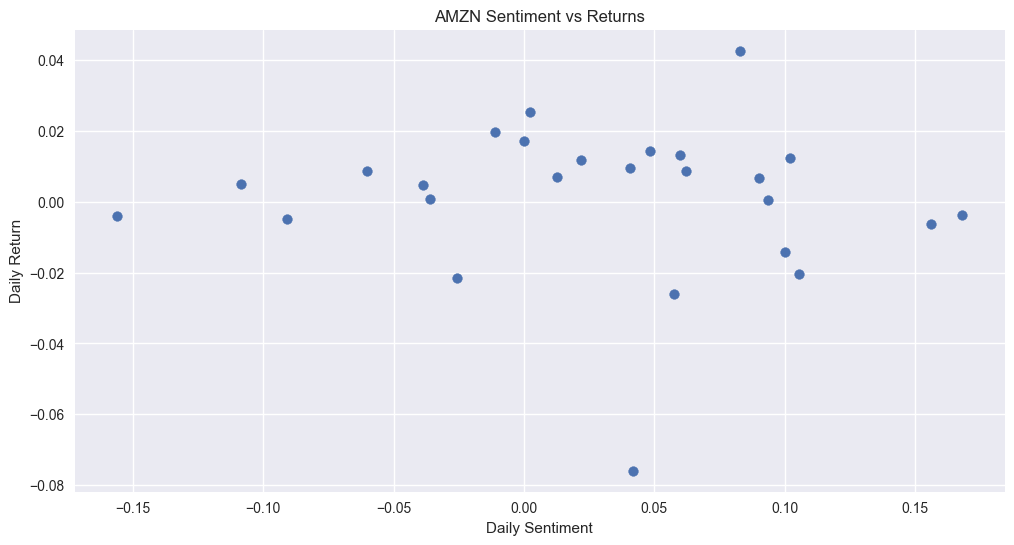

In [97]:


plt.scatter(merged_df['daily_sentiment'], merged_df['return'])
plt.xlabel("Daily Sentiment")
plt.ylabel("Daily Return")
plt.title("AMZN Sentiment vs Returns")
plt.show()


## Interpretation of AMZN Correlation
- The correlation matrices for AMZN show two primary findings:

- Sentiment is Not a Predictor of Returns:

- The correlation between daily sentiment and stock return is essentially zero (around -0.03). This means that a stock's movement on any given day is not influenced by the sentiment expressed in the news on that same day.

- The lagged sentiment (yesterday's news) shows a very weak negative correlation of about -0.17. This is a slight contrarian effect, suggesting that strong positive sentiment one day is marginally associated with a small price pullback the next day. Overall, sentiment is not a meaningful predictor of AMZN returns.

- Sentiment is Highly Volatile:

- The most significant finding is the moderately strong negative correlation (around -0.54) between today's sentiment and yesterday's sentiment. This indicates that the news flow regarding AMZN is highly dynamic; a day of very positive news coverage is often immediately followed by a less positive or neutral/negative day, and vice-versa. Sentiment about AMZN does not persist; it tends to alternate or revert quickly.

## Interpretation of the AMZN Scatter 
- No Relationship or PatternThe most striking feature of this plot is the absence of any discernible pattern or slope. The data points are highly scattered across the entire visible area.
- The cloud of points is nearly circular or randomly distributed, which is the visual signature of zero or near-zero correlation.This confirms the finding from the Pearson and Spearman correlations (which were around -0.03): there is no meaningful linear relationship between the sentiment expressed in the news on a given day and the stock's return on that same day.
2. Tight Range of MovementBoth sentiment and returns are confined to a very narrow band, indicating low volatility during the observed period:Daily Sentiment: Almost all scores fall between -0.10 and +0.10. The most extreme points are near $-0.15$ and $+0.16$.Daily Return: The returns are very small, mostly ranging from -0.02 to +0.02 (or -2% to +2%). The most significant outlier is a negative return of approximately -0.075.

3. Outlier ObservationThere is one distinct outlier point with a relatively low negative return (around -0.075) which is associated with a positive sentiment score (around $+0.05$). This indicates a day where news sentiment was positive, yet the stock price experienced a sharp drop. This visual contrast further undermines any simple cause-and-effect relationship